In [2]:
# import libraries
import time as time
import pandas as pd
import numpy as np
np.random.seed(42)
import sys
import os
import os.path
import itertools
import matplotlib.pyplot as plt

# import custom libraries
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pkgs.loadData import *
from pkgs.svmAlgo import *
from pkgs.results import *
print('packages loaded')

packages loaded


In [3]:
# load data
dataCV, dataTrn, dataTst = loadData('data/csv-format/CVfolds/','data/csv-format/train.csv','data/csv-format/test.csv')

Reading validation fold: 1
   Adding training fold: data/csv-format/CVfolds/fold2.csv
   Adding training fold: data/csv-format/CVfolds/fold3.csv
   Adding training fold: data/csv-format/CVfolds/fold4.csv
   Adding training fold: data/csv-format/CVfolds/fold5.csv
Reading validation fold: 2
   Adding training fold: data/csv-format/CVfolds/fold1.csv
   Adding training fold: data/csv-format/CVfolds/fold3.csv
   Adding training fold: data/csv-format/CVfolds/fold4.csv
   Adding training fold: data/csv-format/CVfolds/fold5.csv
Reading validation fold: 3
   Adding training fold: data/csv-format/CVfolds/fold1.csv
   Adding training fold: data/csv-format/CVfolds/fold2.csv
   Adding training fold: data/csv-format/CVfolds/fold4.csv
   Adding training fold: data/csv-format/CVfolds/fold5.csv
Reading validation fold: 4
   Adding training fold: data/csv-format/CVfolds/fold1.csv
   Adding training fold: data/csv-format/CVfolds/fold2.csv
   Adding training fold: data/csv-format/CVfolds/fold3.csv
   Addi

In [4]:
# run SVM cross validation
def runSVM_CV(dataCV, es):
    # Using current time 
    t_st = time.time()
    
    lrs = [10**0, 10**-1, 10**-2, 10**-3, 10**-4]; #intiial learning rates
    Cs = [10**3, 10**2, 10**1, 10**0, 10**-1, 10**-2,]; #initial tradeoffs    
    hps = list(itertools.product(lrs, Cs))
    best_perf = pd.DataFrame(columns=['Ep','lr', 'C', 'acc', 'obj']); 
    T = 10;
    
    for f in dataCV:
        print('-> Fold -', f, end=" ")
        dataVal = dataCV[f]['val'].to_numpy()
        data = dataCV[f]['trn'];         
        acc0 = 0; # reset accuracy
        
        for lr, C in hps: # for learning rates and tradeoff combinations
            
            # CV training
            w_best, _, lc, obj, losses = svm(data, lr, C, es, T)
            # CV validation
            X = dataVal[:,1:]; X = np.hstack((X, np.ones((X.shape[0],1)))); # add bias
            y = dataVal[:,0];             
            acc_Val = accuracy(X,y,w_best) # accuracy(X,y,w):
        
            if acc_Val > acc0:
                best_perf.loc[f] = [len(lc), lr, C, acc_Val, obj[-1]]
                acc0 = acc_Val
            
    print('\n \n -- SVM Best Performance over CV Folds -- ')
    print(best_perf)     
    print('\nEarly stop:', es)          
    t_en = time.time()
    t_run = np.round((t_en - t_st)/60,3)
    print('\nRuntime (m):', t_run)
    
    return best_perf, t_run

# repeat cross validation
repeats = 3;
reps = {}; runtimes = {}; 
es = 'None'; avgObj = 0; avgAcc  = 0;
for r in range(repeats):
    # input dataCV and early stopping factor
    print('\nTRIAL', r)
    svm_bestHP, t_run = runSVM_CV(dataCV, es);
    avgObj += svm_bestHP.obj.mean();
    avgAcc += svm_bestHP.acc.mean();
    reps[r] = svm_bestHP;
    runtimes[r] = t_run    

# average cross validation objective value for early stopping definition
avgObj = int(avgObj/repeats)
avgCVacc = avgAcc/repeats

print('\nAverage CV accuracy: {:.4f}'.format(avgCVacc))


TRIAL 0
-> Fold - 1 -> Fold - 2 -> Fold - 3 -> Fold - 4 -> Fold - 5 
 
 -- SVM Best Performance over CV Folds -- 
     Ep      lr       C       acc            obj
1  10.0  0.0001  1000.0  0.775785  720122.077462
2  10.0  0.0001  1000.0  0.804933  735390.728313
3  10.0  0.0001  1000.0  0.771300  699961.436950
4  10.0  0.0001  1000.0  0.769058  694207.017259
5  10.0  0.0001  1000.0  0.780269  789174.016367

Early stop: None

Runtime (m): 0.419

TRIAL 1
-> Fold - 1 -> Fold - 2 -> Fold - 3 -> Fold - 4 -> Fold - 5 
 
 -- SVM Best Performance over CV Folds -- 
     Ep      lr       C       acc            obj
1  10.0  0.0001  1000.0  0.784753  713453.001891
2  10.0  0.0001  1000.0  0.802691  766131.733606
3  10.0  0.0001  1000.0  0.769058  707137.951277
4  10.0  0.0001  1000.0  0.769058  698876.275895
5  10.0  0.0001   100.0  0.748879   97952.723131

Early stop: None

Runtime (m): 0.42

TRIAL 2
-> Fold - 1 -> Fold - 2 -> Fold - 3 -> Fold - 4 -> Fold - 5 
 
 -- SVM Best Performance over CV Fo


    Early stop - epoch 26
    Objective values 886509.312 -> 884720.318

Train accuracy: 0.8587


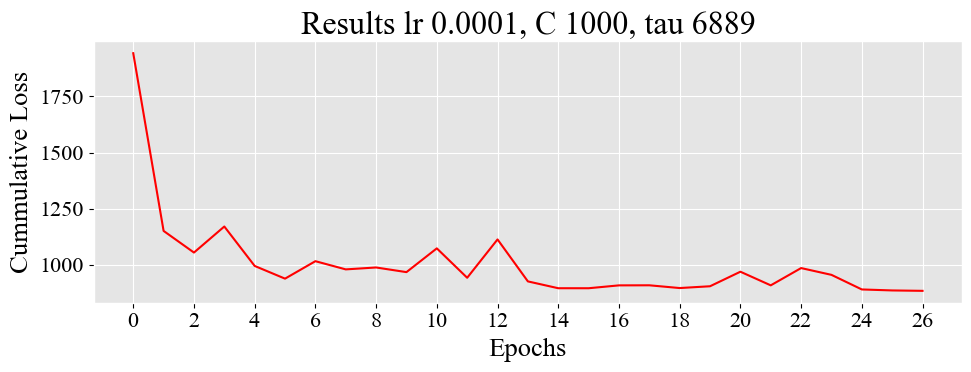

In [6]:
#%% train with best HP

def runSVM_trn(dataTrn, lr, C, tau, T):
    
    w_best, best_acc, lc, obj, losses = svm(dataTrn, lr, C, tau, T)
    
    print('\nTrain accuracy: {:.4f}'.format(best_acc))
        
    return w_best, best_acc, lc, obj, losses

bestLr = 0.0001; bestC = 1000; 
# early stop condition = 1% of avg. CV objective
bestTau = int(0.01*avgObj); T = 100;

svm_Trn = {}
svm_Trn['w'], svm_Trn['Acc'], svm_Trn['LC'], svm_Trn['Obj'], svm_Trn['Losses'] = runSVM_trn(dataTrn, bestLr, bestC, bestTau, T)
     
plot_loss(svm_Trn['Losses'], bestLr, bestC, bestTau, 'svm_trnLoss.pdf')

In [7]:
#%% test with best weight vector

def runSVM_test(dataTst, w):
    
    data_np = dataTst.to_numpy() # split data
    y = data_np[:,0]
    X = data_np[:,1:]
    X = np.hstack((X, np.ones((X.shape[0],1)))) # add bias
    
    acc = accuracy(X,y,w);
    
    print('Test accuracy: {:.4f}'.format(acc))
    
    return acc

tstAcc = runSVM_test(dataTst, svm_Trn['w'])

Test accuracy: 0.8154
